# Install Libraries and Mount Drive

In [1]:
!pip install -q flwr[simulation]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.7/66.7 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.0/236.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.5/542.5 kB 16.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyopenssl 24.2.1 requires cryptography<44,>=41.0.5, but you have cryptography 44.0.2 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.6 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, but you have cr

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries and Set Global Variables

In [2]:
# -*- coding: utf-8 -*-
"""MIMIC-IV Federated Learning with Flower and PyTorch"""

# Install dependencies (Uncomment if running in Colab)
# !pip install -q flwr[simulation] torch torchvision pandas numpy scikit-learn

from collections import OrderedDict
from typing import List, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from typing import List, Tuple, Dict

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg, DifferentialPrivacyClientSideFixedClipping
from flwr.simulation import run_simulation

# Device
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")

# Set up variables
NUM_CLIENTS = 7  # Number of federated clients
NUM_ROUNDS = 10 # Number of rounds


Training on cpu
Flower 1.17.0 / PyTorch 2.6.0+cu124


# Preprocess the Data

In [5]:
# Load datasets
import pandas as pd
from scipy import stats

# Load datasets
DEFAULT_PATH = "/content/drive/MyDrive/MA 591/Dataset/"
BATCH_SIZE = 32

df = pd.read_csv(DEFAULT_PATH + "merged_data_raceincluded.csv")

df.rename(columns={"Temperature (°F)": "Temperature", "hospital_expire_flag":"Hospital_Expire_Flag"}, inplace=True)

features = ['subject_id', 'ABP Diastolic', 'ABP Systolic', 'Glucose', 'Heart Rate', 'Respiratory Rate', 'Temperature', 'race' , 'Hospital_Expire_Flag']
df = df[features]


# Remove outliers
for feature in features:
  if feature not in ['subject_id', 'race' , 'Hospital_Expire_Flag']:
    q_low = df[feature].quantile(0.01)
    q_hi  = df[feature].quantile(0.99)
    df = df[(df[feature] < q_hi) & (df[feature] > q_low)]


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# del round

count_total = df.shape[0]
count_0 = df[df['Hospital_Expire_Flag'] == 0].shape[0]
count_1 = df[df['Hospital_Expire_Flag'] == 1].shape[0]

print(f"~{round(100*count_0/count_total)}% of the data has Hospital_Expire_Flag = 0")
print(f"~{round(100*count_1/count_total)}% of the data has Hospital_Expire_Flag = 1")

# We will make this distribution equal

difference = count_0 - count_1

df_majority = df[df['Hospital_Expire_Flag'] == 0]
df_minority = df[df['Hospital_Expire_Flag'] == 1]

df_majority_downsampled = df_majority.sample(n=count_1, random_state=42)

df = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print("\nBalanced data:")

count_total = df.shape[0]
count_0 = df[df['Hospital_Expire_Flag'] == 0].shape[0]
count_1 = df[df['Hospital_Expire_Flag'] == 1].shape[0]
print(f"~{round(100*count_0/count_total)}% of the data has Hospital_Expire_Flag = 0")
print(f"~{round(100*count_1/count_total)}% of the data has Hospital_Expire_Flag = 1")

# print()

print(df)

~91% of the data has Hospital_Expire_Flag = 0
~9% of the data has Hospital_Expire_Flag = 1

Balanced data:
~50% of the data has Hospital_Expire_Flag = 0
~50% of the data has Hospital_Expire_Flag = 1
      subject_id  ABP Diastolic  ABP Systolic  Glucose  Heart Rate  \
0       16749381          55.45        118.26   135.20       88.56   
1       11929406          50.38        114.92   184.00       97.73   
2       11726221          48.19        116.82   163.50       85.58   
3       12626863          59.44        102.93   167.92      101.50   
4       17264263          63.23        114.59   119.00       89.52   
...          ...            ...           ...      ...         ...   
4721    18690354          54.35         98.98   221.60      108.32   
4722    13390681          64.48        120.39   148.11       79.26   
4723    13197784          61.93        146.90   172.56       91.24   
4724    15947104          79.54        142.47   152.21       91.00   
4725    15218695          67.77

# Analyze the Distributions

Race Distribution:
race
WHITE                                        2794
UNKNOWN                                       788
BLACK/AFRICAN AMERICAN                        256
UNABLE TO OBTAIN                              190
OTHER                                         143
WHITE - OTHER EUROPEAN                        112
ASIAN                                          57
ASIAN - CHINESE                                46
HISPANIC/LATINO - PUERTO RICAN                 43
PATIENT DECLINED TO ANSWER                     36
HISPANIC OR LATINO                             30
BLACK/CARIBBEAN ISLAND                         26
HISPANIC/LATINO - DOMINICAN                    24
WHITE - RUSSIAN                                23
BLACK/CAPE VERDEAN                             21
PORTUGUESE                                     17
BLACK/AFRICAN                                  15
WHITE - EASTERN EUROPEAN                       15
ASIAN - SOUTH EAST ASIAN                       14
ASIAN - ASIAN INDIAN      

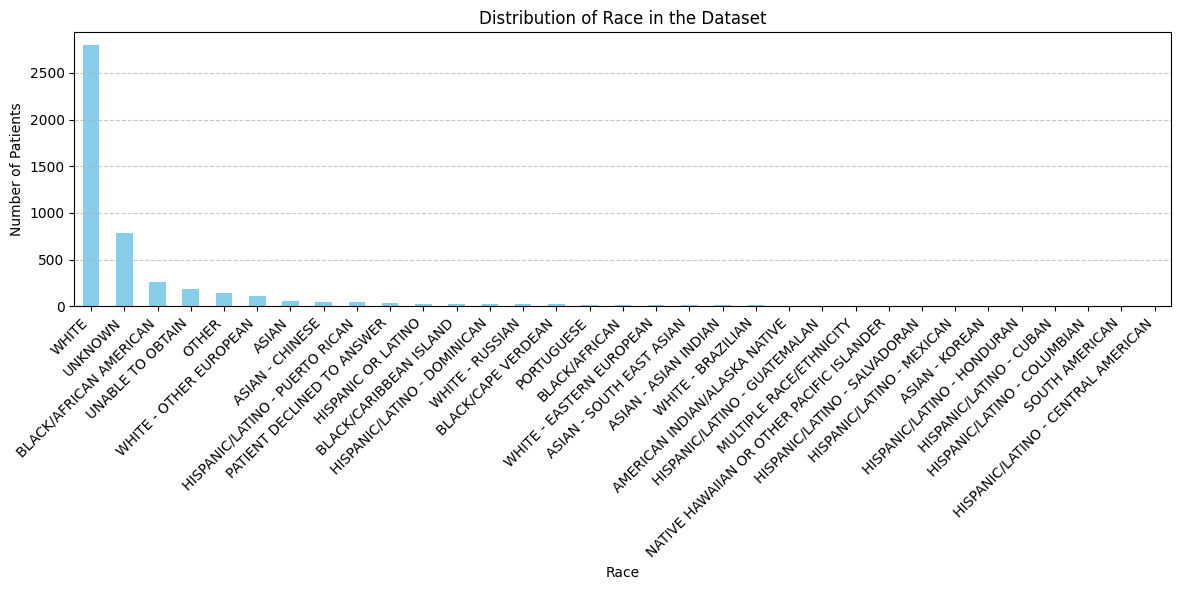

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Count how many entries exist for each race
race_counts = df['race'].value_counts()

# Print the counts
print("Race Distribution:")
print(race_counts)

# Plot as a bar chart
plt.figure(figsize=(12, 6))
race_counts.plot(kind='bar', color='skyblue')
plt.title("Distribution of Race in the Dataset")
plt.xlabel("Race")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Grouped Race Distribution:
race_group
WHITE              2953
UNKNOWN            1014
BLACK               318
OTHER               168
ASIAN               133
HISPANIC/LATINO     127
NATIVE               13
Name: count, dtype: int64


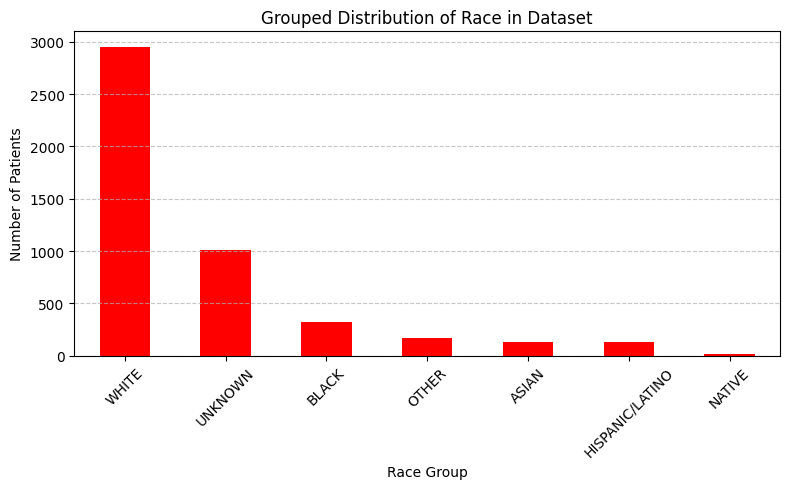

In [7]:
# Define mapping logic
def consolidate_race(race):
    race = race.upper()
    if "WHITE" in race:
        return "WHITE"
    elif "BLACK" in race:
        return "BLACK"
    elif "ASIAN" in race:
        return "ASIAN"
    elif "HISPANIC" in race or "LATINO" in race:
        return "HISPANIC/LATINO"
    elif "UNKNOWN" in race or "UNABLE" in race or "DECLINED" in race:
        return "UNKNOWN"
    elif "NATIVE" in race or "AMERICAN INDIAN" in race:
        return "NATIVE"
    elif "PORTUGUESE" in race or "SOUTH AMERICAN" in race:
        return "OTHER"
    else:
        return "OTHER"

# Apply mapping
df['race_group'] = df['race'].apply(consolidate_race)

# Count and display the grouped race distribution
grouped_counts = df['race_group'].value_counts()
print("Grouped Race Distribution:")
print(grouped_counts)

# Optional: Plot it
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
grouped_counts.plot(kind='bar', color='red')
plt.title("Grouped Distribution of Race in Dataset")
plt.xlabel("Race Group")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [8]:
df_balanced = df

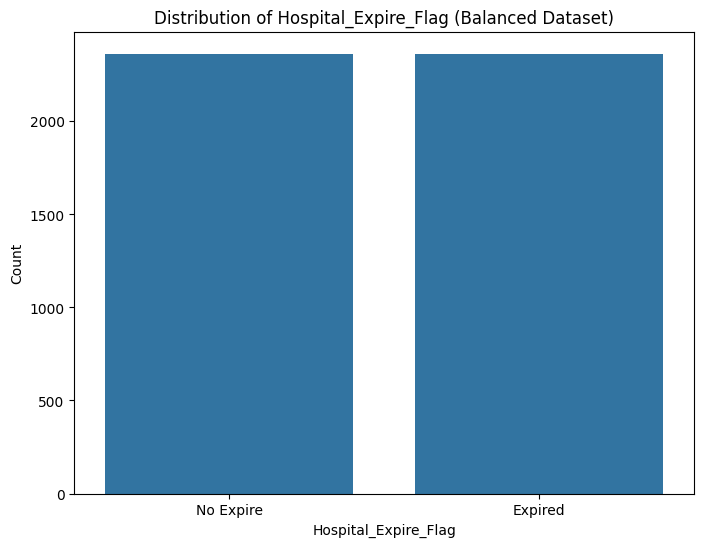

Total Records: 4726
No Expire (0): 2363 records
Expired (1): 2363 records


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Hospital_Expire_Flag', data=df_balanced)
plt.title('Distribution of Hospital_Expire_Flag (Balanced Dataset)')
plt.xlabel('Hospital_Expire_Flag')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Expire', 'Expired'])
plt.show()

count_total = len(df_balanced)
count_0 = df_balanced['Hospital_Expire_Flag'].value_counts()[0]
count_1 = df_balanced['Hospital_Expire_Flag'].value_counts()[1]

print(f"Total Records: {count_total}")
print(f"No Expire (0): {count_0} records")
print(f"Expired (1): {count_1} records")

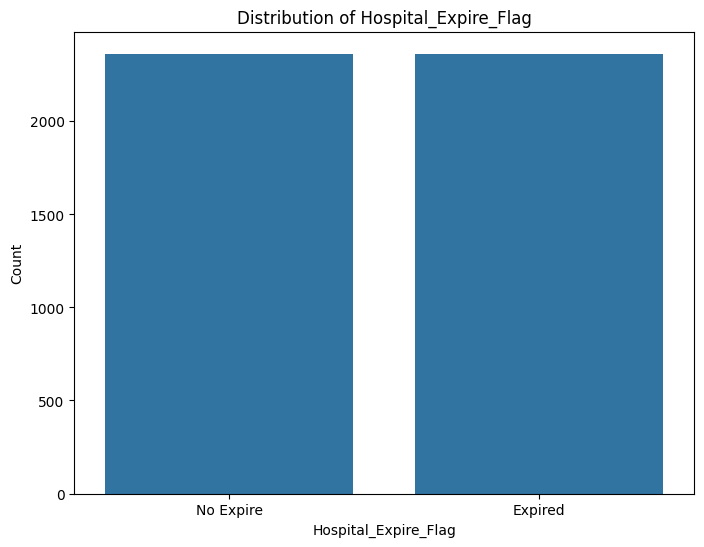

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.countplot(x='Hospital_Expire_Flag', data=df)
plt.title('Distribution of Hospital_Expire_Flag')
plt.xlabel('Hospital_Expire_Flag')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Expire', 'Expired'])
plt.show()

count_total = len(df)
count_0 = df['Hospital_Expire_Flag'].value_counts()[0]
count_1 = df['Hospital_Expire_Flag'].value_counts()[1]



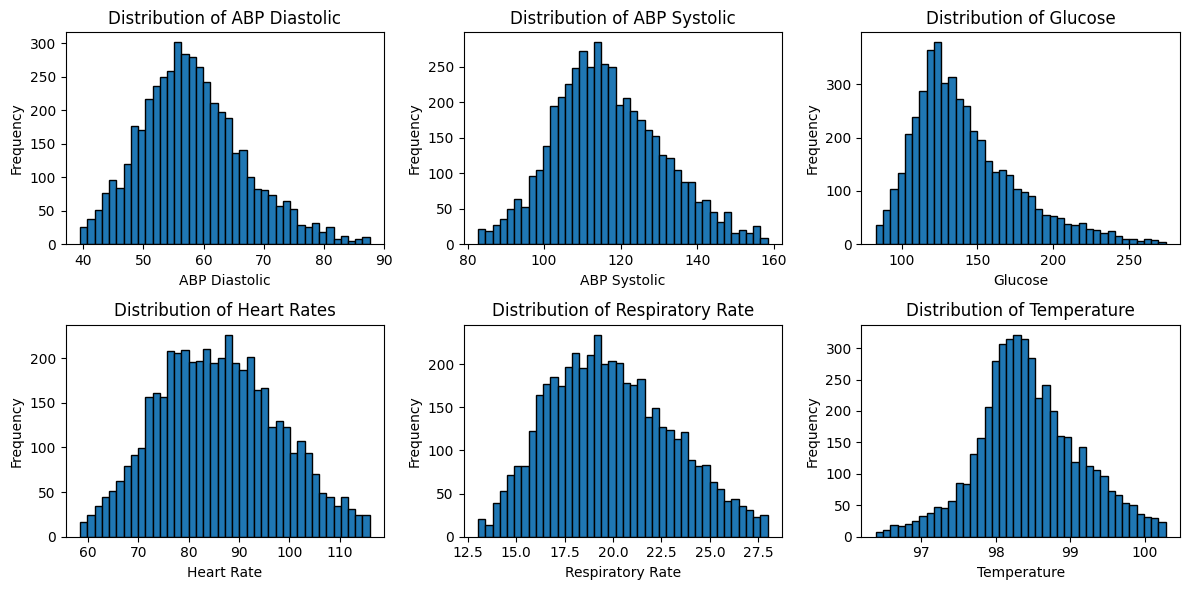

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(12, 6))  # 2 rows, 3 columns

# List of variables and corresponding axes positions
variables = ['ABP Diastolic', 'ABP Systolic', 'Glucose', 'Heart Rate', 'Respiratory Rate', 'Temperature']
titles = ["Distribution of ABP Diastolic", "Distribution of ABP Systolic", "Distribution of Glucose",
          "Distribution of Heart Rates", "Distribution of Respiratory Rate", "Distribution of Temperature"]

# Flatten axes for easier iteration
axes = axes.flatten()

# Loop through variables and plot
for i, var in enumerate(variables):
    axes[i].hist(df[var], bins=40, edgecolor='black')
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Run Federated Learning

In [14]:
torch.manual_seed(1)

# Apply transformation
df['race_group'] = df['race'].apply(consolidate_race)

# Prepare datasets_by_race
datasets_by_race = {}
scaler = StandardScaler()

for race in df_balanced['race_group'].unique():
    race_df = df_balanced[df_balanced['race_group'] == race]
    X = race_df.drop(columns=["subject_id", "Hospital_Expire_Flag", "race", "race_group"])
    y = race_df["Hospital_Expire_Flag"]


    X_scaled = scaler.fit_transform(X)
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

    datasets_by_race[race] = {
        "train": TensorDataset(X_train_tensor, y_train_tensor),
        "val": TensorDataset(X_val_tensor, y_val_tensor)
    }

race_labels = sorted(list(datasets_by_race.keys()))
NUM_CLIENTS = len(race_labels)

print("\nClient to Race Group Mapping:")
for idx, race in enumerate(race_labels):
    print(f"Client {idx} => Race Group: {race}")

# Define model
class MortalityNN(nn.Module):
    def __init__(self, input_dim):
        super(MortalityNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.sigmoid(self.fc3(x))

# Training and testing

def train(net, trainloader, epochs: int):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    net.train()
    for epoch in range(epochs):
        for X_batch, y_batch in trainloader:
            optimizer.zero_grad()
            y_pred = net(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

def test(net, testloader):
    criterion = nn.BCELoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for X_batch, y_batch in testloader:
            y_pred = net(X_batch)
            loss += criterion(y_pred, y_batch).item()
            predicted = (y_pred > 0.5).float()
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    return loss / len(testloader.dataset), correct / total

# Flower Client
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        return [val.cpu().numpy() for _, val in self.net.state_dict().items()]

    def set_parameters(self, parameters):
        params_dict = zip(self.net.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        self.net.load_state_dict(state_dict, strict=True)

    def fit(self, parameters, config):
        self.set_parameters(parameters)
        train(self.net, self.trainloader, epochs=10)
        return self.get_parameters(config), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        self.set_parameters(parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader.dataset), {"accuracy": float(accuracy)}

# Client selector by race
def client_fn(context: Context):
    partition_id = context.node_config["partition-id"]
    race = race_labels[partition_id]
    data = datasets_by_race[race]

    model = MortalityNN(next(iter(DataLoader(data["train"], batch_size=1)))[0].shape[1])
    train_loader = DataLoader(data["train"], batch_size=32, shuffle=True)
    val_loader = DataLoader(data["val"], batch_size=32)

    return FlowerClient(model, train_loader, val_loader).to_client()

client_app = ClientApp(
    client_fn=client_fn,
)

# FedAvg strategy with logging
class DummyIns:
    def __init__(self, config):
        self.config = config

class LoggingFedAvg(FedAvg):
    def __init__(self, *args, **kwargs):
        super(LoggingFedAvg, self).__init__(*args, **kwargs)
        self.client_weights_history = []
        self.accuracies = []

    def aggregate_fit(self, rnd: int, results, failures):
        round_client_weights = []
        for fit_res in results:
            param_obj = fit_res[0]
            dummy_ins = DummyIns(config={})
            param_obj = param_obj.get_parameters(timeout=10, group_id="", ins=dummy_ins)
            if hasattr(param_obj, "parameters"):
                param_obj = param_obj.parameters
            round_client_weights.append(param_obj)
        self.client_weights_history.append({"round": rnd, "client_weights": round_client_weights})
        return super().aggregate_fit(rnd, results, failures)

    def aggregate_evaluate(self, rnd: int, results, failures):
        if results:
            self.accuracies.append(results)
        return super().aggregate_evaluate(rnd, results, failures)

# Weighted average for aggregation
def weighted_average(metrics: List[Tuple[int, Dict]]) -> Dict:
    accuracies = [num_examples * m["accuracy"] for num_examples, m in metrics]
    examples = [num_examples for num_examples, _ in metrics]
    return {"accuracy": sum(accuracies) / sum(examples)}

# Server function
NUM_ROUNDS = 25
strategy = LoggingFedAvg(
    fraction_fit=1.0,
    fraction_evaluate=1.0,
    min_fit_clients=NUM_CLIENTS,
    min_evaluate_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    evaluate_metrics_aggregation_fn=weighted_average
)

def server_fn(context: Context) -> ServerAppComponents:
    return ServerAppComponents(strategy=strategy, config=ServerConfig(num_rounds=NUM_ROUNDS))

server_app = ServerApp(server_fn=server_fn)

# Backend config
DEVICE = "cpu"
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}
if DEVICE == "cuda":
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

# Run simulation
result = run_simulation(
    server_app=server_app,
    client_app=client_app,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config,
)

INFO :      Starting Flower ServerApp, config: num_rounds=25, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client



Client to Race Group Mapping:
Client 0 => Race Group: ASIAN
Client 1 => Race Group: BLACK
Client 2 => Race Group: HISPANIC/LATINO
Client 3 => Race Group: NATIVE
Client 4 => Race Group: OTHER
Client 5 => Race Group: UNKNOWN
Client 6 => Race Group: WHITE


(pid=4458) 2025-04-18 18:38:32.284167: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=4458) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=4458) E0000 00:00:1745001512.328153    4458 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
(pid=4458) E0000 00:00:1745001512.340198    4458 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO :      Received initial parameters from one random client
INFO :      Starting evaluation of initial global parameters
INFO :      Evaluation returned no results (`None`)
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 7 clients (out of 7)
INFO :      aggregate_fit: rec

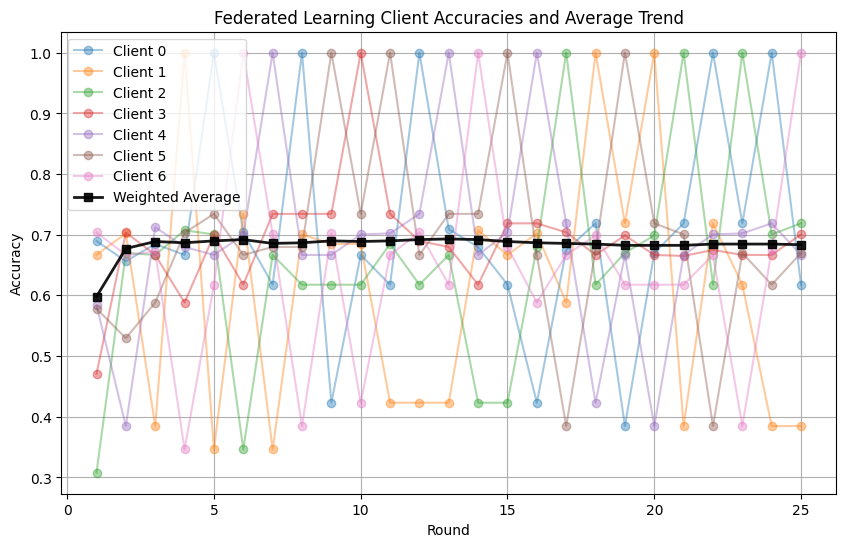

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sanity check to ensure the number of rounds match
assert len(strategy.accuracies) == NUM_ROUNDS

# Initialize dictionaries
accuracies = {}
num_examples_per_client = {}

for client in range(NUM_CLIENTS):
    client_name = f"Client {client}"
    accuracies[client_name] = []
    num_examples_per_client[client_name] = []

# Extract per-client accuracy and number of examples from EvaluateRes
for round in range(NUM_ROUNDS):
    for client in range(NUM_CLIENTS):
        client_name = f"Client {client}"
        _, eval_res_obj = strategy.accuracies[round][client]  # Second item is EvaluateRes
        acc = eval_res_obj.metrics["accuracy"]
        num_ex = eval_res_obj.num_examples
        accuracies[client_name].append(acc)
        num_examples_per_client[client_name].append(num_ex)

# Sanity check to make sure each client has data for all rounds
assert len(next(iter(accuracies.values()))) == NUM_ROUNDS

# Calculate the weighted average accuracy per round
avg_accuracies = []
for round in range(NUM_ROUNDS):
    total_weighted_accuracy = 0
    total_examples = 0
    for client in range(NUM_CLIENTS):
        client_name = f"Client {client}"
        acc = accuracies[client_name][round]
        num_ex = num_examples_per_client[client_name][round]
        total_weighted_accuracy += acc * num_ex
        total_examples += num_ex
    weighted_avg = total_weighted_accuracy / total_examples if total_examples > 0 else 0
    avg_accuracies.append(weighted_avg)

# Plot each client's accuracy
plt.figure(figsize=(10, 6))
for client_name, acc_values in accuracies.items():
    plt.plot(range(1, NUM_ROUNDS + 1), acc_values, marker='o', linestyle='-', label=client_name, alpha=0.4)

# Plot the weighted average accuracy trend
plt.plot(range(1, NUM_ROUNDS + 1), avg_accuracies, marker='s', linestyle='-', color='black', linewidth=2, label="Weighted Average", alpha=0.9)

# Labels and title
plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.title("Federated Learning Client Accuracies and Average Trend")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [20]:
def run_dp_simulation(epsilon: float) -> float:
    import numpy as np
    from flwr.client.mod import LocalDpMod

    # Define new local DP mod with updated epsilon
    dp_mod = LocalDpMod(clipping_norm=5.0, sensitivity=1.0, epsilon=epsilon, delta=1e-5)

    client_app = ClientApp(
        client_fn=client_fn,
        mods=[dp_mod],
    )

    # Set up the strategy with logging for accuracy
    strategy = LoggingFedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=NUM_CLIENTS,
        min_evaluate_clients=NUM_CLIENTS,
        min_available_clients=NUM_CLIENTS,
        evaluate_metrics_aggregation_fn=weighted_average,
    )

    server_app = ServerApp(server_fn=lambda context: ServerAppComponents(
        strategy=strategy,
        config=ServerConfig(num_rounds=NUM_ROUNDS)
    ))

    # Run the simulation
    result = run_simulation(
        server_app=server_app,
        client_app=client_app,
        num_supernodes=NUM_CLIENTS,
        backend_config=backend_config,
    )

    # Extract client accuracies from EvaluateRes objects
    accuracies = {}
    num_examples_per_client = {}

    for client in range(NUM_CLIENTS):
        client_name = f"Client {client}"
        accuracies[client_name] = []
        num_examples_per_client[client_name] = []

    for round in range(NUM_ROUNDS):
        for client in range(NUM_CLIENTS):
            client_name = f"Client {client}"
            _, eval_res = strategy.accuracies[round][client]  # (proxy, EvaluateRes)
            acc = eval_res.metrics["accuracy"]
            num_ex = eval_res.num_examples
            accuracies[client_name].append(acc)
            num_examples_per_client[client_name].append(num_ex)

    # Compute weighted average accuracy for final round
    total_weighted_accuracy = 0
    total_examples = 0
    for client in range(NUM_CLIENTS):
        client_name = f"Client {client}"
        acc = accuracies[client_name][-1]  # Last round accuracy
        num_ex = num_examples_per_client[client_name][-1]
        total_weighted_accuracy += acc * num_ex
        total_examples += num_ex

    weighted_acc = total_weighted_accuracy / total_examples if total_examples > 0 else 0.0
    return weighted_acc

epsilon_values = [0.1, 0.5, 1, 2, 5, 10, 50, 100]
results = [(eps, run_dp_simulation(eps)) for eps in epsilon_values]


Streaming output truncated to the last 5000 lines.
    values, debugger_breakpoint = worker.get_objects(object_refs, timeout=timeout)
                                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ray/_private/worker.py", line 864, in get_objects
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(ClientAppException): ray::ClientAppActor.run() (pid=7473, ip=172.28.0.12, actor_id=1529862ced0c3f3876b6530c01000000, repr=<flwr.simulation.ray_transport.ray_actor.ClientAppActor object at 0x79e90b757010>)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/client_app.py", line 144, in __call__
    return self._call(message, context)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flwr/client/mod/utils.py", line 27, in new_ffn
    return _mod(message, context, _ffn)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

In [1]:
import matplotlib.pyplot as plt

epsilons, weighted_accuracies = zip(*results)
plt.figure(figsize=(8, 5))
plt.plot(epsilons, weighted_accuracies, marker='o')
plt.xscale("log")
plt.xlabel("Epsilon (Privacy Level)")
plt.ylabel("Accuracy (Final Round)")
plt.title("Privacy vs Accuracy (DP Epsilon Sweep)")
plt.grid(True)
plt.show()


NameError: name 'results' is not defined